In [1]:
import torch 
import torchvision
import time
import copy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model_name="resnet50" #resnet50模型
feature_extract = True #设置是否使用模型的预训练参数
classify_num = 30 # 分类数量

In [3]:
train_device = torch.cuda.is_available()

if train_device:
    print("GPU获取成功，train将在gpu上.....")
else:
    print("GPU获取失败，train将CPU上.....")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU获取成功，train将在gpu上.....


In [4]:
# 冻结不需要训练的层
def set_parameter_requerd_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
# model_dl = torchvision.models.resnet50()
# model_dl
# 初始化模型
def initialize_model(is_use_preWeights, classify_num):
    model_dl = torchvision.models.resnet50(weights=torchvision.models.resnet.ResNet50_Weights.IMAGENET1K_V2) #使用预训练参数
    set_parameter_requerd_grad(model_dl, is_use_preWeights) #是否冻结卷积层
    num_in_fea = model_dl.fc.in_features
    model_dl.fc = torch.nn.Sequential(torch.nn.Linear(num_in_fea, classify_num),
                                     torch.nn.LogSoftmax(dim=1))
    return model_dl
# initialize_model(feature_extract, classify_num)


In [6]:
model_dl = initialize_model(feature_extract, classify_num) # 构造模型
model_save_filename = "model_dl02.pth"
num_epoch = 1000

# 打印出哪些参数需要做训练
print("这些参数需要做训练：")
param_update = []
for name, param in model_dl.named_parameters():
    if param.requires_grad  == True:
        param_update.append(param)
        print("\t",name)
# param_update

这些参数需要做训练：
	 fc.0.weight
	 fc.0.bias


In [7]:
# 设置优化器，学习率，损失函数
optimizer = torch.optim.SGD(param_update,lr= 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.1)
# 动态学习率，测试10轮，每三轮学习率变为原来的0.1
loss_fun = torch.nn.NLLLoss()

In [8]:
# 定义训练函数
def train(model, dataloader, loss_fun, optim, num_epoch, save_path):
    best_acc = 0 # 记录下最优的那个模型准确率
    model.to(device)# 使用gpu
    
    train_acc_history = []
    train_losses = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epoch):
        start = time.time() # 计时
        print("一共{}轮，第{}轮".format(num_epoch,epoch + 1))
        print("-"*10)
        
        running_loss = 0.0
        running_corrects = 0
        
        # 开始训练
        model.train() # train模式
         # 遍历数据
        for imgs, targets in dataloader["train"]:
            imgs = imgs.to(device)
            targets = targets.to(device)
            optim.zero_grad()
            outputs = model(imgs)
            loss = loss_fun(outputs, targets)
            loss.backward()
            optim.step()
            preds = outputs.argmax(1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += torch.sum(preds == targets.data)

        epoch_loss = running_loss / len(dataloader["train"].dataset)
        epoch_acc = running_corrects / len(dataloader["train"].dataset)
        epoch_time = time.time() - start

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            state = {
                "state_dict" : model.state_dict(),
                "best_acc" : best_acc,
                "optimizer" : optim.state_dict()
            }
            torch.save(state, save_path)
        print("该轮训练结束，用时{}，Loss：{:.2f}，Accuracy:{:.4f},Best_Accracy:{:.4f}"
              .format(epoch_time,epoch_loss,epoch_acc,best_acc))

In [10]:
# 处理数据
data_dir = "../DataSet/Agricultural-crops/"
batch_size = 8 

In [11]:
def make_data_frame(root_path, batch_size):
    dataset = torchvision.datasets.ImageFolder(root_path, 
                                                 torchvision.transforms.Compose([
                                                     torchvision.transforms.RandomRotation(45), # 旋转
                                                     torchvision.transforms.CenterCrop(224), # 裁剪
                                                     torchvision.transforms.ToTensor(),
                                                     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                 ]))
#     print(len(dataset))
#     print(dataset.classes)
    cat_to_name = dataset.class_to_idx
    valid_percent = int(len(dataset) * 0.2) 
#     train_data : valid_data = 8 : 2
    train_percent = len(dataset) - valid_percent
    train_data, valid_data = torch.utils.data.random_split(dataset, [train_percent, valid_percent])
    dataloader = {index : torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle = True) for index, data in [("train", train_data), ("valid", valid_data)]}
    return dataloader, cat_to_name

In [12]:
dataloader, cat_to_name = make_data_frame(data_dir, batch_size)
cat_to_name = dict(zip(cat_to_name.values(), cat_to_name.keys()))
print(cat_to_name)
dataloader
# make_data_frame(data_dir, batch_size)

{0: 'Cherry', 1: 'Coffee-plant', 2: 'Cucumber', 3: 'Fox_nut(Makhana)', 4: 'Lemon', 5: 'Olive-tree', 6: 'Pearl_millet(bajra)', 7: 'Tobacco-plant', 8: 'almond', 9: 'banana', 10: 'cardamom', 11: 'chilli', 12: 'clove', 13: 'coconut', 14: 'cotton', 15: 'gram', 16: 'jowar', 17: 'jute', 18: 'maize', 19: 'mustard-oil', 20: 'papaya', 21: 'pineapple', 22: 'rice', 23: 'soyabean', 24: 'sugarcane', 25: 'sunflower', 26: 'tea', 27: 'tomato', 28: 'vigna-radiati(Mung)', 29: 'wheat'}


{'train': <torch.utils.data.dataloader.DataLoader at 0x1205e2bd460>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x1205e2bda30>}

In [138]:
# 训练fc
train(model_dl, dataloader, loss_fun, optimizer, num_epoch, model_save_filename)

一共1000轮，第1轮
----------
该轮训练结束，用时14.750816583633423，Loss：3.40，Accuracy:0.0361,Best_Accracy:0.0361
一共1000轮，第2轮
----------
该轮训练结束，用时14.415946245193481，Loss：3.40，Accuracy:0.0422,Best_Accracy:0.0422
一共1000轮，第3轮
----------
该轮训练结束，用时14.316194772720337，Loss：3.39，Accuracy:0.0572,Best_Accracy:0.0572
一共1000轮，第4轮
----------
该轮训练结束，用时14.401745080947876，Loss：3.39，Accuracy:0.0467,Best_Accracy:0.0572
一共1000轮，第5轮
----------
该轮训练结束，用时14.347158670425415，Loss：3.37，Accuracy:0.0648,Best_Accracy:0.0648
一共1000轮，第6轮
----------
该轮训练结束，用时14.436996936798096，Loss：3.37，Accuracy:0.0648,Best_Accracy:0.0648
一共1000轮，第7轮
----------
该轮训练结束，用时14.567063808441162，Loss：3.36，Accuracy:0.0768,Best_Accracy:0.0768
一共1000轮，第8轮
----------
该轮训练结束，用时15.123747110366821，Loss：3.35，Accuracy:0.0994,Best_Accracy:0.0994
一共1000轮，第9轮
----------
该轮训练结束，用时15.999028205871582，Loss：3.35，Accuracy:0.0889,Best_Accracy:0.0994
一共1000轮，第10轮
----------
该轮训练结束，用时16.19802165031433，Loss：3.34，Accuracy:0.1190,Best_Accracy:0.1190
一共1000轮，第11轮
----------
该轮训练结束

该轮训练结束，用时16.804158687591553，Loss：2.87，Accuracy:0.4669,Best_Accracy:0.4940
一共1000轮，第86轮
----------
该轮训练结束，用时16.975533485412598，Loss：2.86，Accuracy:0.4774,Best_Accracy:0.4940
一共1000轮，第87轮
----------
该轮训练结束，用时16.70940327644348，Loss：2.86，Accuracy:0.4864,Best_Accracy:0.4940
一共1000轮，第88轮
----------
该轮训练结束，用时16.894815921783447，Loss：2.85，Accuracy:0.4819,Best_Accracy:0.4940
一共1000轮，第89轮
----------
该轮训练结束，用时16.81011986732483，Loss：2.84，Accuracy:0.4834,Best_Accracy:0.4940
一共1000轮，第90轮
----------
该轮训练结束，用时17.007508516311646，Loss：2.84，Accuracy:0.4970,Best_Accracy:0.4970
一共1000轮，第91轮
----------
该轮训练结束，用时16.65407133102417，Loss：2.82，Accuracy:0.4774,Best_Accracy:0.4970
一共1000轮，第92轮
----------
该轮训练结束，用时16.870830297470093，Loss：2.82，Accuracy:0.4910,Best_Accracy:0.4970
一共1000轮，第93轮
----------
该轮训练结束，用时16.992995023727417，Loss：2.82，Accuracy:0.5015,Best_Accracy:0.5015
一共1000轮，第94轮
----------
该轮训练结束，用时17.088865518569946，Loss：2.83，Accuracy:0.4925,Best_Accracy:0.5015
一共1000轮，第95轮
----------
该轮训练结束，用时16.60203003883

该轮训练结束，用时22.868218898773193，Loss：2.44，Accuracy:0.6280,Best_Accracy:0.6340
一共1000轮，第170轮
----------
该轮训练结束，用时22.713776111602783，Loss：2.45，Accuracy:0.6175,Best_Accracy:0.6340
一共1000轮，第171轮
----------
该轮训练结束，用时22.588499069213867，Loss：2.44，Accuracy:0.6084,Best_Accracy:0.6340
一共1000轮，第172轮
----------
该轮训练结束，用时22.83930540084839，Loss：2.45，Accuracy:0.6265,Best_Accracy:0.6340
一共1000轮，第173轮
----------
该轮训练结束，用时22.26198959350586，Loss：2.44，Accuracy:0.6265,Best_Accracy:0.6340
一共1000轮，第174轮
----------
该轮训练结束，用时21.981327533721924，Loss：2.42，Accuracy:0.6175,Best_Accracy:0.6340
一共1000轮，第175轮
----------
该轮训练结束，用时22.25213074684143，Loss：2.42，Accuracy:0.6340,Best_Accracy:0.6340
一共1000轮，第176轮
----------
该轮训练结束，用时22.66200590133667，Loss：2.42，Accuracy:0.6506,Best_Accracy:0.6506
一共1000轮，第177轮
----------
该轮训练结束，用时23.671550512313843，Loss：2.42，Accuracy:0.6370,Best_Accracy:0.6506
一共1000轮，第178轮
----------
该轮训练结束，用时22.82937502861023，Loss：2.39，Accuracy:0.6370,Best_Accracy:0.6506
一共1000轮，第179轮
----------
该轮训练结束，用时22.745

该轮训练结束，用时17.195955276489258，Loss：2.14，Accuracy:0.7063,Best_Accracy:0.7244
一共1000轮，第254轮
----------
该轮训练结束，用时16.879193782806396，Loss：2.10，Accuracy:0.7003,Best_Accracy:0.7244
一共1000轮，第255轮
----------
该轮训练结束，用时17.11767601966858，Loss：2.11，Accuracy:0.7244,Best_Accracy:0.7244
一共1000轮，第256轮
----------
该轮训练结束，用时17.379236698150635，Loss：2.12，Accuracy:0.7003,Best_Accracy:0.7244
一共1000轮，第257轮
----------
该轮训练结束，用时17.33418846130371，Loss：2.11，Accuracy:0.7018,Best_Accracy:0.7244
一共1000轮，第258轮
----------
该轮训练结束，用时17.090620756149292，Loss：2.10，Accuracy:0.7123,Best_Accracy:0.7244
一共1000轮，第259轮
----------
该轮训练结束，用时17.1796875，Loss：2.09，Accuracy:0.7169,Best_Accracy:0.7244
一共1000轮，第260轮
----------
该轮训练结束，用时17.03976345062256，Loss：2.10，Accuracy:0.7003,Best_Accracy:0.7244
一共1000轮，第261轮
----------
该轮训练结束，用时17.079777002334595，Loss：2.10，Accuracy:0.7033,Best_Accracy:0.7244
一共1000轮，第262轮
----------
该轮训练结束，用时17.25406312942505，Loss：2.10，Accuracy:0.7244,Best_Accracy:0.7244
一共1000轮，第263轮
----------
该轮训练结束，用时17.3755803108

该轮训练结束，用时16.672590970993042，Loss：1.86，Accuracy:0.7515,Best_Accracy:0.7636
一共1000轮，第338轮
----------
该轮训练结束，用时16.830890417099，Loss：1.86，Accuracy:0.7500,Best_Accracy:0.7636
一共1000轮，第339轮
----------
该轮训练结束，用时17.488513708114624，Loss：1.88，Accuracy:0.7470,Best_Accracy:0.7636
一共1000轮，第340轮
----------
该轮训练结束，用时18.51038932800293，Loss：1.86，Accuracy:0.7560,Best_Accracy:0.7636
一共1000轮，第341轮
----------
该轮训练结束，用时17.974506855010986，Loss：1.86，Accuracy:0.7605,Best_Accracy:0.7636
一共1000轮，第342轮
----------
该轮训练结束，用时16.921119213104248，Loss：1.83，Accuracy:0.7771,Best_Accracy:0.7771
一共1000轮，第343轮
----------
该轮训练结束，用时17.391310214996338，Loss：1.85，Accuracy:0.7620,Best_Accracy:0.7771
一共1000轮，第344轮
----------
该轮训练结束，用时17.196727991104126，Loss：1.85，Accuracy:0.7575,Best_Accracy:0.7771
一共1000轮，第345轮
----------
该轮训练结束，用时16.871910095214844，Loss：1.83，Accuracy:0.7485,Best_Accracy:0.7771
一共1000轮，第346轮
----------
该轮训练结束，用时16.782514810562134，Loss：1.85，Accuracy:0.7605,Best_Accracy:0.7771
一共1000轮，第347轮
----------
该轮训练结束，用时17.28

该轮训练结束，用时17.032958030700684，Loss：1.66，Accuracy:0.7892,Best_Accracy:0.8057
一共1000轮，第422轮
----------
该轮训练结束，用时16.970688581466675，Loss：1.66，Accuracy:0.7756,Best_Accracy:0.8057
一共1000轮，第423轮
----------
该轮训练结束，用时17.01260209083557，Loss：1.67，Accuracy:0.7786,Best_Accracy:0.8057
一共1000轮，第424轮
----------
该轮训练结束，用时17.245525121688843，Loss：1.68，Accuracy:0.7831,Best_Accracy:0.8057
一共1000轮，第425轮
----------
该轮训练结束，用时16.962647199630737，Loss：1.66，Accuracy:0.7861,Best_Accracy:0.8057
一共1000轮，第426轮
----------
该轮训练结束，用时16.54532527923584，Loss：1.62，Accuracy:0.8042,Best_Accracy:0.8057
一共1000轮，第427轮
----------
该轮训练结束，用时16.835659503936768，Loss：1.64，Accuracy:0.8027,Best_Accracy:0.8057
一共1000轮，第428轮
----------
该轮训练结束，用时17.56812834739685，Loss：1.67，Accuracy:0.7771,Best_Accracy:0.8057
一共1000轮，第429轮
----------
该轮训练结束，用时16.97396183013916，Loss：1.65，Accuracy:0.7922,Best_Accracy:0.8057
一共1000轮，第430轮
----------
该轮训练结束，用时16.70431661605835，Loss：1.65，Accuracy:0.7877,Best_Accracy:0.8057
一共1000轮，第431轮
----------
该轮训练结束，用时17.071

该轮训练结束，用时17.25744318962097，Loss：1.50，Accuracy:0.8072,Best_Accracy:0.8313
一共1000轮，第506轮
----------
该轮训练结束，用时17.309282302856445，Loss：1.53，Accuracy:0.7982,Best_Accracy:0.8313
一共1000轮，第507轮
----------
该轮训练结束，用时17.00627374649048，Loss：1.49，Accuracy:0.8253,Best_Accracy:0.8313
一共1000轮，第508轮
----------
该轮训练结束，用时17.081401586532593，Loss：1.51，Accuracy:0.8238,Best_Accracy:0.8313
一共1000轮，第509轮
----------
该轮训练结束，用时16.66397786140442，Loss：1.51，Accuracy:0.8193,Best_Accracy:0.8313
一共1000轮，第510轮
----------
该轮训练结束，用时16.703806400299072，Loss：1.50，Accuracy:0.8027,Best_Accracy:0.8313
一共1000轮，第511轮
----------
该轮训练结束，用时16.69161081314087，Loss：1.48，Accuracy:0.8027,Best_Accracy:0.8313
一共1000轮，第512轮
----------
该轮训练结束，用时16.962407112121582，Loss：1.49，Accuracy:0.8057,Best_Accracy:0.8313
一共1000轮，第513轮
----------
该轮训练结束，用时16.715654850006104，Loss：1.51，Accuracy:0.8012,Best_Accracy:0.8313
一共1000轮，第514轮
----------
该轮训练结束，用时16.59076690673828，Loss：1.49，Accuracy:0.8117,Best_Accracy:0.8313
一共1000轮，第515轮
----------
该轮训练结束，用时16.800

该轮训练结束，用时18.21329355239868，Loss：1.38，Accuracy:0.8283,Best_Accracy:0.8494
一共1000轮，第590轮
----------
该轮训练结束，用时19.236480474472046，Loss：1.40，Accuracy:0.8298,Best_Accracy:0.8494
一共1000轮，第591轮
----------
该轮训练结束，用时19.50907564163208，Loss：1.38，Accuracy:0.8223,Best_Accracy:0.8494
一共1000轮，第592轮
----------
该轮训练结束，用时18.150198459625244，Loss：1.41，Accuracy:0.8238,Best_Accracy:0.8494
一共1000轮，第593轮
----------
该轮训练结束，用时18.88342308998108，Loss：1.35，Accuracy:0.8419,Best_Accracy:0.8494
一共1000轮，第594轮
----------
该轮训练结束，用时18.166419744491577，Loss：1.38，Accuracy:0.8328,Best_Accracy:0.8494
一共1000轮，第595轮
----------
该轮训练结束，用时18.842448949813843，Loss：1.36，Accuracy:0.8404,Best_Accracy:0.8494
一共1000轮，第596轮
----------
该轮训练结束，用时18.174124240875244，Loss：1.39，Accuracy:0.8208,Best_Accracy:0.8494
一共1000轮，第597轮
----------
该轮训练结束，用时18.33160376548767，Loss：1.38，Accuracy:0.8358,Best_Accracy:0.8494
一共1000轮，第598轮
----------
该轮训练结束，用时18.128645658493042，Loss：1.34，Accuracy:0.8373,Best_Accracy:0.8494
一共1000轮，第599轮
----------
该轮训练结束，用时17.92

该轮训练结束，用时17.99049973487854，Loss：1.26，Accuracy:0.8238,Best_Accracy:0.8599
一共1000轮，第674轮
----------
该轮训练结束，用时18.8157901763916，Loss：1.28，Accuracy:0.8358,Best_Accracy:0.8599
一共1000轮，第675轮
----------
该轮训练结束，用时18.223522901535034，Loss：1.31，Accuracy:0.8178,Best_Accracy:0.8599
一共1000轮，第676轮
----------
该轮训练结束，用时17.937318086624146，Loss：1.27，Accuracy:0.8419,Best_Accracy:0.8599
一共1000轮，第677轮
----------
该轮训练结束，用时18.475371837615967，Loss：1.26，Accuracy:0.8584,Best_Accracy:0.8599
一共1000轮，第678轮
----------
该轮训练结束，用时20.25405526161194，Loss：1.27，Accuracy:0.8298,Best_Accracy:0.8599
一共1000轮，第679轮
----------
该轮训练结束，用时18.387327909469604，Loss：1.27，Accuracy:0.8328,Best_Accracy:0.8599
一共1000轮，第680轮
----------
该轮训练结束，用时17.980803966522217，Loss：1.25，Accuracy:0.8434,Best_Accracy:0.8599
一共1000轮，第681轮
----------
该轮训练结束，用时18.481733322143555，Loss：1.24，Accuracy:0.8389,Best_Accracy:0.8599
一共1000轮，第682轮
----------
该轮训练结束，用时19.370144605636597，Loss：1.26，Accuracy:0.8449,Best_Accracy:0.8599
一共1000轮，第683轮
----------
该轮训练结束，用时20.33

该轮训练结束，用时17.49204444885254，Loss：1.20，Accuracy:0.8373,Best_Accracy:0.8720
一共1000轮，第758轮
----------
该轮训练结束，用时21.12642478942871，Loss：1.18，Accuracy:0.8599,Best_Accracy:0.8720
一共1000轮，第759轮
----------
该轮训练结束，用时18.358532428741455，Loss：1.19，Accuracy:0.8479,Best_Accracy:0.8720
一共1000轮，第760轮
----------
该轮训练结束，用时19.44123935699463，Loss：1.16，Accuracy:0.8599,Best_Accracy:0.8720
一共1000轮，第761轮
----------
该轮训练结束，用时18.72747540473938，Loss：1.14，Accuracy:0.8630,Best_Accracy:0.8720
一共1000轮，第762轮
----------
该轮训练结束，用时19.69344162940979，Loss：1.15，Accuracy:0.8509,Best_Accracy:0.8720
一共1000轮，第763轮
----------
该轮训练结束，用时20.74161195755005，Loss：1.16，Accuracy:0.8449,Best_Accracy:0.8720
一共1000轮，第764轮
----------
该轮训练结束，用时19.271450757980347，Loss：1.18，Accuracy:0.8479,Best_Accracy:0.8720
一共1000轮，第765轮
----------
该轮训练结束，用时18.548892736434937，Loss：1.21，Accuracy:0.8283,Best_Accracy:0.8720
一共1000轮，第766轮
----------
该轮训练结束，用时20.197713136672974，Loss：1.18，Accuracy:0.8449,Best_Accracy:0.8720
一共1000轮，第767轮
----------
该轮训练结束，用时20.1420

该轮训练结束，用时20.88242793083191，Loss：1.12，Accuracy:0.8434,Best_Accracy:0.8810
一共1000轮，第842轮
----------
该轮训练结束，用时18.74564290046692，Loss：1.10，Accuracy:0.8404,Best_Accracy:0.8810
一共1000轮，第843轮
----------
该轮训练结束，用时18.196181297302246，Loss：1.09，Accuracy:0.8645,Best_Accracy:0.8810
一共1000轮，第844轮
----------
该轮训练结束，用时18.95969820022583，Loss：1.08，Accuracy:0.8690,Best_Accracy:0.8810
一共1000轮，第845轮
----------
该轮训练结束，用时17.72614598274231，Loss：1.08，Accuracy:0.8630,Best_Accracy:0.8810
一共1000轮，第846轮
----------
该轮训练结束，用时17.702935457229614，Loss：1.09，Accuracy:0.8419,Best_Accracy:0.8810
一共1000轮，第847轮
----------
该轮训练结束，用时17.361902713775635，Loss：1.13，Accuracy:0.8404,Best_Accracy:0.8810
一共1000轮，第848轮
----------
该轮训练结束，用时17.872107982635498，Loss：1.08，Accuracy:0.8660,Best_Accracy:0.8810
一共1000轮，第849轮
----------
该轮训练结束，用时17.61036491394043，Loss：1.09，Accuracy:0.8795,Best_Accracy:0.8810
一共1000轮，第850轮
----------
该轮训练结束，用时17.476614475250244，Loss：1.11，Accuracy:0.8614,Best_Accracy:0.8810
一共1000轮，第851轮
----------
该轮训练结束，用时17.308

该轮训练结束，用时17.072232723236084，Loss：1.04，Accuracy:0.8539,Best_Accracy:0.8825
一共1000轮，第926轮
----------
该轮训练结束，用时17.552631855010986，Loss：1.07，Accuracy:0.8750,Best_Accracy:0.8825
一共1000轮，第927轮
----------
该轮训练结束，用时16.810691833496094，Loss：1.01，Accuracy:0.8675,Best_Accracy:0.8825
一共1000轮，第928轮
----------
该轮训练结束，用时17.019667387008667，Loss：1.04，Accuracy:0.8690,Best_Accracy:0.8825
一共1000轮，第929轮
----------
该轮训练结束，用时17.09217596054077，Loss：1.03，Accuracy:0.8810,Best_Accracy:0.8825
一共1000轮，第930轮
----------
该轮训练结束，用时17.91250705718994，Loss：1.03，Accuracy:0.8645,Best_Accracy:0.8825
一共1000轮，第931轮
----------
该轮训练结束，用时17.01779794692993，Loss：1.05，Accuracy:0.8675,Best_Accracy:0.8825
一共1000轮，第932轮
----------
该轮训练结束，用时17.2940890789032，Loss：1.01，Accuracy:0.8765,Best_Accracy:0.8825
一共1000轮，第933轮
----------
该轮训练结束，用时17.136176109313965，Loss：1.01，Accuracy:0.8795,Best_Accracy:0.8825
一共1000轮，第934轮
----------
该轮训练结束，用时17.309356451034546，Loss：1.01，Accuracy:0.8855,Best_Accracy:0.8855
一共1000轮，第935轮
----------
该轮训练结束，用时17.503

In [12]:
model_dl_test = initialize_model(feature_extract, classify_num)
model_dl_test.to(device)
state = torch.load("./model_dl02.pth")
model_dl_test.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [13]:
# 测试
valid_data_iter = iter(dataloader['valid'])
imgs, targets = valid_data_iter.next()

if train_device:
    outputs = model_dl_test(imgs.to(device))
else:
    outputs = model_dl_test(imgs)

torch.Size([32, 30])
[ 3  3 29  7 15 25 27  6 13  6  8 18  7  7  9 19 14 12  0 26 24 14  6  2
 19 13  5 26  2 10 15 27]


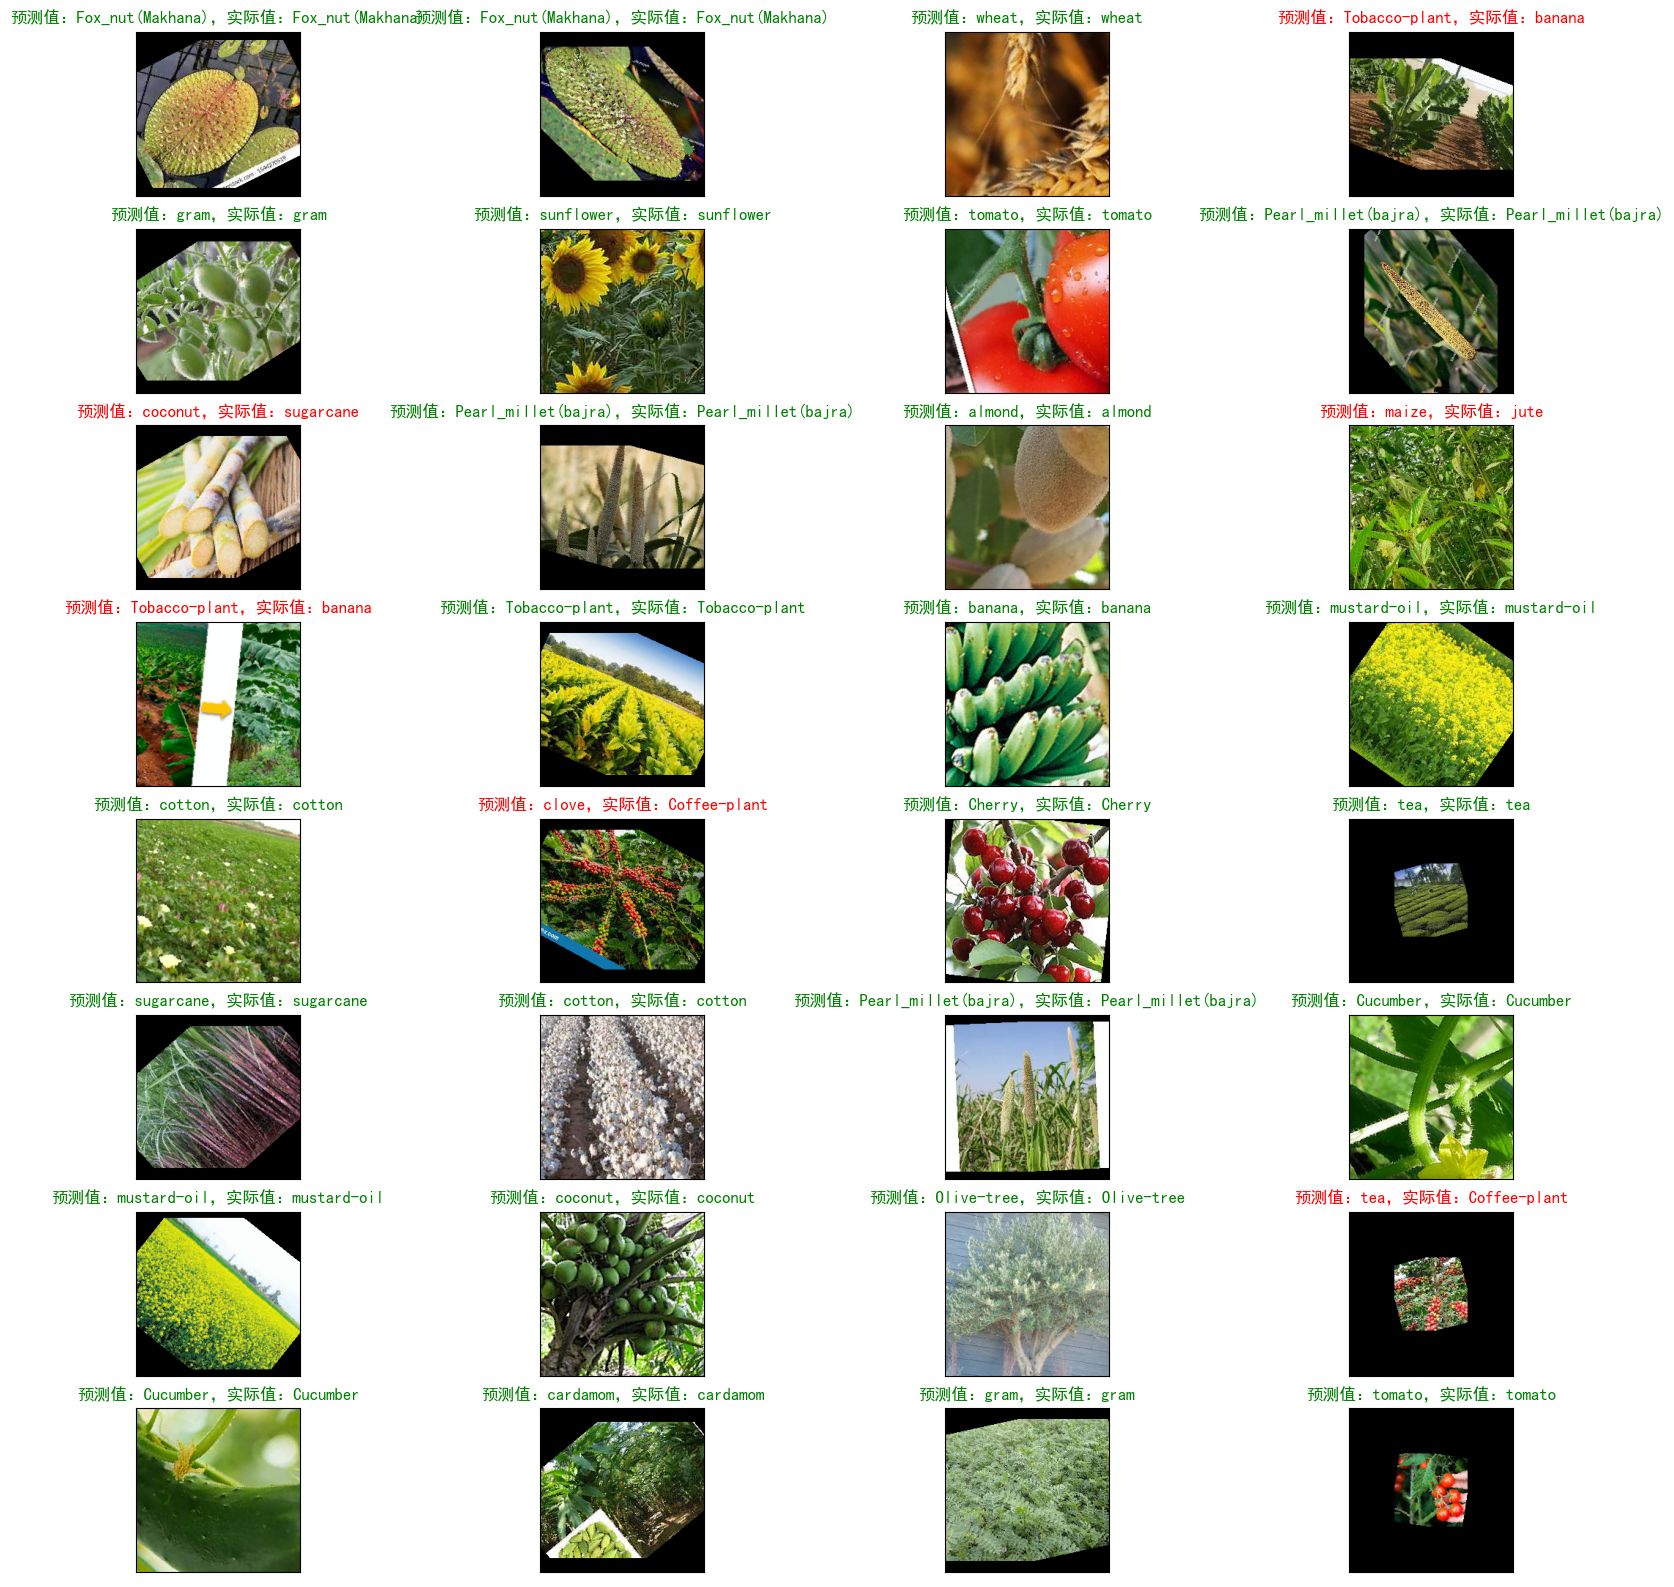

In [14]:
# 测试结果可视化
print(outputs.shape) # 结果形状
if train_device:
    preds = outputs.argmax(1).cpu().numpy()
else:
    preds = outputs.argmax(1).numpy()
print(preds)

plt.rcParams["font.sans-serif"]=["simhei"]
plt.rcParams["axes.unicode_minus"]=False
fig = plt.figure(figsize=(20, 20))
col = 4
row = 8
for index in range(col * row):
    ax = fig.add_subplot(row, col, index+1, xticks=[], yticks=[])
    image = imgs[index]
    image = np.array(image).transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    ax.set_title("预测值：{}，实际值：{}".format(cat_to_name[preds[index]], cat_to_name[targets[index].item()]),
                color=("green" if cat_to_name[preds[index]] == cat_to_name[targets[index].item()] else "red")) 

In [16]:
preds_right = 0
print("数据集长度：{}".format(len(dataloader["valid"].dataset)))
for imgs, targets in dataloader['valid']:
    imgs = imgs.to(device)
    targets = targets.to(device)
    outputs = model_dl_test(imgs)
    preds = outputs.argmax(1)
    preds_right += torch.sum(preds == targets.data)

print("accuracy:{:.2f}%".format((preds_right.item() / len(dataloader["valid"].dataset) * 100)))
# 过了一夜还变厉害了我靠！！

数据集长度：165
accuracy:84.24%


In [13]:
# 在之前的基础上再整体训练一遍
# 放开冻结的层
feature_extract = False
model_save_filename = "model_dl03.pth" # 模型保存到的路径
model_dl_03 = initialize_model(feature_extract, classify_num)
state = torch.load("./model_dl02.pth")
model_dl_03.load_state_dict(state["state_dict"]) # 加载之前模型参数

<All keys matched successfully>

In [14]:
# 打印出哪些参数需要做训练
print("这些参数需要做训练：")
param_update = []
for name, param in model_dl_03.named_parameters():
    if param.requires_grad  == True:
        param_update.append(param)
        print("\t",name)

这些参数需要做训练：
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 lay

In [15]:
# 200轮
train(model_dl_03, dataloader, loss_fun, optimizer, 200, model_save_filename)

一共200轮，第1轮
----------
该轮训练结束，用时39.79148888587952，Loss：1.58，Accuracy:0.7485,Best_Accracy:0.7485
一共200轮，第2轮
----------
该轮训练结束，用时36.897741079330444，Loss：1.56，Accuracy:0.7605,Best_Accracy:0.7605
一共200轮，第3轮
----------
该轮训练结束，用时36.86115789413452，Loss：1.55，Accuracy:0.7605,Best_Accracy:0.7605
一共200轮，第4轮
----------
该轮训练结束，用时36.8228805065155，Loss：1.55，Accuracy:0.7636,Best_Accracy:0.7636
一共200轮，第5轮
----------
该轮训练结束，用时38.004140853881836，Loss：1.55，Accuracy:0.7741,Best_Accracy:0.7741
一共200轮，第6轮
----------
该轮训练结束，用时39.82060408592224，Loss：1.55，Accuracy:0.7786,Best_Accracy:0.7786
一共200轮，第7轮
----------
该轮训练结束，用时40.33886456489563，Loss：1.53，Accuracy:0.7636,Best_Accracy:0.7786
一共200轮，第8轮
----------
该轮训练结束，用时39.94607615470886，Loss：1.53，Accuracy:0.7801,Best_Accracy:0.7801
一共200轮，第9轮
----------
该轮训练结束，用时39.98266816139221，Loss：1.59，Accuracy:0.7440,Best_Accracy:0.7801
一共200轮，第10轮
----------
该轮训练结束，用时39.98752021789551，Loss：1.57，Accuracy:0.7470,Best_Accracy:0.7801
一共200轮，第11轮
----------
该轮训练结束，用时40.1942679882049

该轮训练结束，用时40.29206585884094，Loss：1.57，Accuracy:0.7455,Best_Accracy:0.7861
一共200轮，第88轮
----------
该轮训练结束，用时40.666465282440186，Loss：1.56，Accuracy:0.7651,Best_Accracy:0.7861
一共200轮，第89轮
----------
该轮训练结束，用时40.853092193603516，Loss：1.53，Accuracy:0.7816,Best_Accracy:0.7861
一共200轮，第90轮
----------
该轮训练结束，用时40.193434715270996，Loss：1.53，Accuracy:0.7907,Best_Accracy:0.7907
一共200轮，第91轮
----------
该轮训练结束，用时40.357704877853394，Loss：1.51，Accuracy:0.7786,Best_Accracy:0.7907
一共200轮，第92轮
----------
该轮训练结束，用时40.471725940704346，Loss：1.53，Accuracy:0.7846,Best_Accracy:0.7907
一共200轮，第93轮
----------
该轮训练结束，用时40.69715070724487，Loss：1.56，Accuracy:0.7515,Best_Accracy:0.7907
一共200轮，第94轮
----------
该轮训练结束，用时40.29589033126831，Loss：1.56，Accuracy:0.7846,Best_Accracy:0.7907
一共200轮，第95轮
----------
该轮训练结束，用时40.21950078010559，Loss：1.53，Accuracy:0.7590,Best_Accracy:0.7907
一共200轮，第96轮
----------
该轮训练结束，用时40.3271598815918，Loss：1.55，Accuracy:0.7530,Best_Accracy:0.7907
一共200轮，第97轮
----------
该轮训练结束，用时40.55960416793823，Loss：1.56

该轮训练结束，用时45.97007989883423，Loss：1.55，Accuracy:0.7575,Best_Accracy:0.7907
一共200轮，第173轮
----------
该轮训练结束，用时42.39753699302673，Loss：1.55，Accuracy:0.7877,Best_Accracy:0.7907
一共200轮，第174轮
----------
该轮训练结束，用时41.35196089744568，Loss：1.57，Accuracy:0.7455,Best_Accracy:0.7907
一共200轮，第175轮
----------
该轮训练结束，用时41.01552391052246，Loss：1.55，Accuracy:0.7530,Best_Accracy:0.7907
一共200轮，第176轮
----------
该轮训练结束，用时41.14666152000427，Loss：1.56，Accuracy:0.7380,Best_Accracy:0.7907
一共200轮，第177轮
----------
该轮训练结束，用时40.368199825286865，Loss：1.55，Accuracy:0.7726,Best_Accracy:0.7907
一共200轮，第178轮
----------
该轮训练结束，用时40.64081144332886，Loss：1.56，Accuracy:0.7530,Best_Accracy:0.7907
一共200轮，第179轮
----------
该轮训练结束，用时40.891801834106445，Loss：1.53，Accuracy:0.7560,Best_Accracy:0.7907
一共200轮，第180轮
----------
该轮训练结束，用时40.73991537094116，Loss：1.55，Accuracy:0.7756,Best_Accracy:0.7907
一共200轮，第181轮
----------
该轮训练结束，用时41.00043535232544，Loss：1.57，Accuracy:0.7620,Best_Accracy:0.7907
一共200轮，第182轮
----------
该轮训练结束，用时40.378424882888794，

In [20]:
preds_right = 0
print("数据集长度：{}".format(len(dataloader["valid"].dataset)))
for imgs, targets in dataloader['valid']:
    imgs = imgs.to(device)
    targets = targets.to(device)
    outputs = model_dl_03(imgs)
    preds = outputs.argmax(1)
    preds_right += torch.sum(preds == targets.data)

print("accuracy:{:.2f}%".format((preds_right.item() / len(dataloader["valid"].dataset) * 100)))

数据集长度：165
accuracy:78.18%
